In [2]:
!python --version

Python 3.10.12


## Setup

In [ ]:
# !mamba install fastai 

# cannot install duckduckgo_search with mamba
# !pip install duckduckgo_search

In [36]:
from duckduckgo_search.duckduckgo_search import DDGS
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url

In [ ]:
# ??ddg_images
# ??DDGS.images

## Step 1: Prepare Data

### Search single image

In [35]:
def search_image(keyword, max_images=30):
    print(f"Searching for '{keyword}'")
    # DDGS().images() return a iterator of dictionary objects
    # each obj has following key: {'title': '...', 'image': '...', 'thumbnail': '...', 'url': '...', 
    #                             'height': 1200, 'width': 1600, 'source': 'Bing'}
    # convert it to L obj (fastai): https://fastcore.fast.ai/foundation.html#l-helpers 
    # L: count# objs & list of dic object
    # func itemgot: get value of key "image" in each dictionary item
    return L(DDGS().images(keywords=keyword, max_results=max_images)).itemgot("image")

In [ ]:
urls = search_image("elephant", max_images=2)
urls[0]

In [ ]:
# download one url & take a look
# ??download_url
dest = "elephant.jpg"
download_url(url=urls[0], dest=dest, show_progress=False)

# show
img = Image.open(dest)
img.to_thumb(256, 256)

### Search a number of image

In [10]:
search_terms = ["elephant", "forest"]
path = Path("data/elephant_or_not")
from time import sleep

is_download = False
if is_download:
    path.mkdir(exist_ok=True)
    for t in search_terms:
        dest = (path/t)
        dest.mkdir(exist_ok=True)
        #
        # func download_images of fastai/vision/utils.py
        download_images(dest=dest, urls=search_image(keyword=f"{t} photo"))
        sleep(10)
        #
        # download shade photos ()
        download_images(dest=dest, urls=search_image(keyword=f"{t} shade photo"))
        sleep(10)
        #
        #  func of fastai/vision/utils.py
        resize_images(path/t, max_size=400, dest=path/t)

In [ ]:
# ??dest.mkdir

In [ ]:
# ??resize_images

In [ ]:
# ??download_images

## Step 2: Training model

In [ ]:
# ??get_image_files
# get_image_files(path)

In [ ]:
# verify images
# ??verify_images
# fastai/vision/utils.py
# Find images in `fns` that can't be opened"
invalid_images = verify_images(get_image_files(path))
invalid_images

In [ ]:
invalid_images.map(Path.unlink)

In [ ]:
# double-check
verify_images(get_image_files(path))

**Note**: to avoid error

```
RuntimeError: The MPS backend is supported on MacOS 12.3+.Current OS version can be queried using sw_vers

```

Because my current MacOS is 13.4 (I think I will use Unbuntu instead of MacOS @@)
we set property `device` in dataloaders() func to `cpu`

In [ ]:
# prepare data
# ??DataBlock
# 
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(size=192, method="squish")]
).dataloaders(path, bs=32, device='cpu')

dls.show_batch(max_n=6)

/Users/hatruong/miniforge3/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


In [ ]:
# ??RandomSplitter
# ??DataBlock
#
# fastai/data/transforms.py
# ??parent_label
#
# ??Resize
# ??get_image_files
#
# ??Resize
#
# ??DataBlock.dataloaders

In [ ]:
#
# fastai.vision.learner.vision_learner
# vision_learner
#
# torchvision/models/resnet.py
# I guess fastai import torchvision somewhere in src code
# resnet18
#
# fastai.metrics.error_rate
# error_rate

In [ ]:
??vision_learner

In [28]:
from fastai.vision import learner
# stats = learner.model_meta.get(resnet18, learner._default_meta).get('stats')
# stats
learner.model_meta[resnet18]["stats"] = learner.model_meta[resnet18]["stats"] + (1, 4, False,)
# learner.model_meta[resnet18]["stats"] = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 1, 4, False)
learner.model_meta[resnet18]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 1, 4, False)}

In [30]:
# class NormalizeTest():
#     "Normalize/denorm batch of `TensorImage`"
#     parameters,order = L('mean', 'std'),99
#     def __init__(self, mean=None, std=None, axes=(0,2,3)): store_attr()

#     @classmethod
#     def from_stats(cls, mean, std, dim=1, ndim=4, cuda=True): 
#         print("mean", mean)
#         print("std", std)
#         print('dim', dim)
#         print('ndim', ndim)
#         print('cuda', cuda)
# NormalizeTest.from_stats(*learner.model_meta[resnet18]['stats'])

mean [0.485, 0.456, 0.406]
std [0.229, 0.224, 0.225]
dim 1
ndim 4
cuda False


In [31]:
# train
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/hatruong/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hatruong/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hatruong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.8MB/

epoch,train_loss,valid_loss,error_rate,time
0,0.947583,0.583886,0.230769,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.145322,0.119506,0.076923,00:10
1,0.076010,0.120713,0.057692,00:11
2,0.063483,0.102065,0.057692,00:11


### Step 3: use model

Searching for 'big elephant'


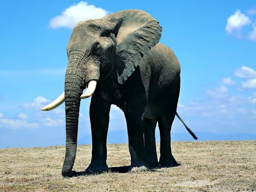

In [37]:
dest_test = "elephant_test.jpg"
urls = search_image("big elephant", max_images=2)
urls[0]
download_url(url=urls[0], dest=dest_test, show_progress=False)

# show
img = Image.open(dest_test)
img.to_thumb(256, 256)

This is a: forest.
Probability it's an elephant: 0.0000
Probability it's a forest: 1.0000


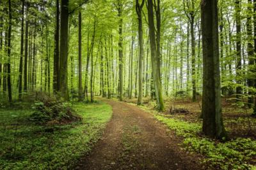

In [46]:
img_test = get_image_files((path/'forest'))[0]
is_elephant, _, probs = learn.predict(PILImage.create(img_test))
print(f"This is a: {is_elephant}.")
print(f"Probability it's an elephant: {probs[0]:.4f}")
print(f"Probability it's a forest: {probs[1]:.4f}")
# show
img = Image.open(img_test)
img.to_thumb(256, 256)

Path('elephant_or_not/forest/04bf29be-3248-4266-bbcf-c30d46cc198f.jpg')